# CIFAR10 AISToS Kaggle Competition
---
Our team is composed by :
- Nick "Neocortical" Tsakiris
- George Spiropoulos
- Hercules Konsoulas

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive")
os.chdir('/content/drive/MyDrive/')

print('\n',os.getcwd())
print("\n")
print(os.listdir())

save_dir = os.path.join(os.getcwd(),'saved_models')

In [ ]:
# Importing base libraries
import matplotlib.pyplot as plt
import numpy as np
import csv

# Importing TF modules
import keras
import tensorflow as tf

from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Concatenate, AveragePooling2D, Input, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 5s 0us/step


# Data Visualization

In [ ]:
print("Training dataset shape : ",x_train.shape)
print("Training dataset labels' shape : ",y_train.shape)

print("Test dataset shape : ",x_test.shape)
print("Test dataset labels' shape : ",y_test.shape)

Training dataset shape :  (50000, 32, 32, 3)
Training dataset labels' shape :  (50000, 1)
Test dataset shape :  (10000, 32, 32, 3)
Test dataset labels' shape :  (10000, 1)


In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts

In [ ]:
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

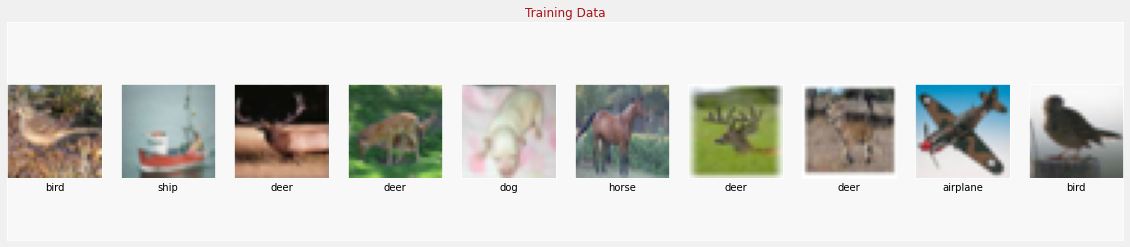

In [ ]:
display_images(x_train, y_train, y_train, "Training Data" )

# Prepping data

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [ ]:
x_train = preprocess_image_input(x_train)
x_test = preprocess_image_input(x_test)

In [ ]:
##### Should we split the data into validation and train? #####
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.2)

# Model builing

Μετά από πολλές δοκιμές καταλήξαμε στο ότι το μοντέλο μας έδινε καλύτερα αποτελέσματα αν το εκπαιδεύαμε με transfer learning.

Transfer Learning ονομάζεται η διαδικασία κατασκευής ενός μοντέλου χρησιμοποιόντας άλλα προϋπάρχοντα μοντέλα (Χτίζοντας δηλαδή ενα καινούριο μοντέλο γύρω απο το προϋπάρχον), εκμεταλλευόντας έτσι την εγγυημένη επιτυχία τους.

Μεταξύ των μοντέλων που δοκιμάσαμε έιναι και τα εξής :
* ResNet50
* InceptionV3
* DenseNet121
* Και πολλά άλλα

## ResNet Transfer Learning

In [ ]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x)
  x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
  return x

def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

def ResNetTransfer():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

### Model Preparation, Compilation and Visualisation

In [ ]:
model_name = 'cifar10_% s_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment. 
checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor ='val_acc',
                             verbose = 1,
                             save_best_only = True)

early_stopping = EarlyStopping(
    monitor="val_loss",
    #min_delta=0,
    patience=2,
    verbose=1,
    mode="auto",
    #baseline=None,
    restore_best_weights=True)

callbacks = [checkpoint,
             #lr_scheduler
             #lr_reducer,
             early_stopping 
             ]

In [ ]:
model = ResNetTransfer()

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
______________________________________________________________

### Fitting

In [ ]:
BATCH_SIZE = 64
EPOCHS = 3

history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data = (x_val, y_val), batch_size=BATCH_SIZE, callbacks = callbacks)

Epoch 1/3
625/625 [==============================] - 440s 643ms/step - loss: 0.8450 - accuracy: 0.7248 - val_loss: 0.2351 - val_accuracy: 0.9190
Epoch 2/3
625/625 [==============================] - 409s 654ms/step - loss: 0.1205 - accuracy: 0.9586 - val_loss: 0.1681 - val_accuracy: 0.9445
Epoch 3/3
625/625 [==============================] - 410s 655ms/step - loss: 0.0413 - accuracy: 0.9882 - val_loss: 0.1641 - val_accuracy: 0.9505


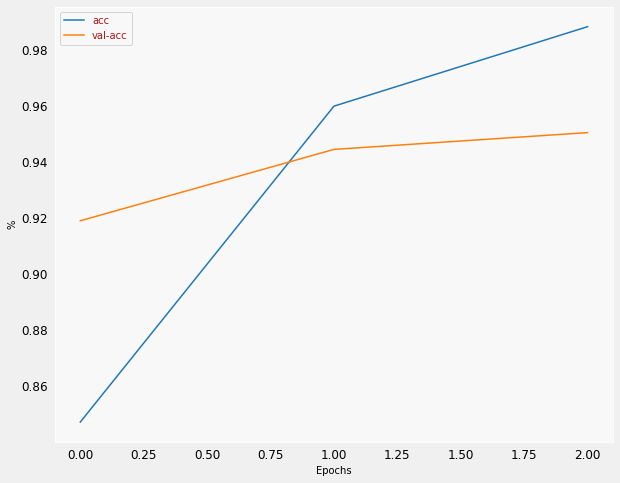

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)

In [ ]:
#model = load_model('./saved_models/cifar10_% s_model.005.h5')
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 30s 96ms/step - loss: 0.1705 - accuracy: 0.9458
Test loss: 0.17054714262485504
Test accuracy: 0.9458000063896179


## InceptionV3 Transfer Learning

In [ ]:
def augmentation(x_train, y_train, batch_size):
  datagen = ImageDataGenerator(#horizontal_flip = True,
                               #vertical_flip= True,
                               rotation_range= 30,
                               #zoom_range = 0.2,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1)
  
  it_train = datagen.flow(x_train,
                          y_train,
                          batch_size = batch_size)
  return it_train

iterator = augmentation(x_train, y_train, batch_size)

In [ ]:
def feature_extractor(inputs):
  return tf.keras.applications.InceptionV3(input_shape= (224, 224, 3),
                                               include_top = False)(inputs)

def incV3():
  inputs = Input(shape=(32, 32, 3))
  x = tf.keras.layers.UpSampling2D(size = (7, 7))(inputs)
  x = feature_extractor(x)
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(1024, activation= 'relu')(x)
  x = Dense(512, activation= 'relu')(x)
  x = Dropout(.5)(x)
  outputs = Dense(10, activation = 'softmax')(x)
  model = Model(inputs, outputs)

  return model

### Model Preparation, Compilation and Visualisation

In [ ]:
model = incV3()
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ['acc'])
model.summary()

In [ ]:
plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# Prepare model model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_% s_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
  
# Prepare callbacks for model saving and for learning rate adjustment. 
checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor ='val_acc',
                             verbose = 1,
                             save_best_only = True)

# Learning rate scheduler & Reduce on Plateau

def lr_schedule(epoch):
  lr = 1e-2
  if (epoch>140) :
      lr *= 0.5e-3
  elif epoch > 120:
      lr *= 1e-3
  elif epoch > 80:
      lr *= 1e-2
  elif epoch > 40:
      lr *= 1e-1
  return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               patience=5,
                               min_lr=0.5e-6,)

early_stopping = EarlyStopping(
    monitor="val_loss",
    #min_delta=0,
    patience=15,
    verbose=1,
    mode="auto",
    #baseline=None,
    restore_best_weights=True,
)
  
callbacks = [checkpoint,
             #lr_scheduler
             #lr_reducer,
             early_stopping 
             ]

### Fitting

In [ ]:
epochs = 5

history = model.fit(x_train,
                    t_train,
                    epochs = epochs,
                    validation_data = (x_val, t_val),
                    batch_size = batch_size,
                    callbacks = callbacks)

In [ ]:
model = load_model('./saved_models/cifar10_% s_model.005.h5')
scores = model.evaluate(x_test, t_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)

In [ ]:
#model = load_model('./saved_models/cifar10_% s_model.005.h5')
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

## Xception

In [ ]:
def feature_extractor(inputs):
  return tf.keras.applications.Xception(input_shape= (224, 224, 3),
                                               include_top = False)(inputs)

def xception():
  inputs = Input(shape=(32, 32, 3))
  x = tf.keras.layers.UpSampling2D(size = (7, 7))(inputs)
  x = feature_extractor(x)
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  """x = Dense(1024, activation= 'relu')(x)
  x = Dense(512, activation= 'relu')(x)
  x = Dropout(.5)(x)"""
  outputs = Dense(10, activation = 'softmax')(x)
  model = Model(inputs, outputs)

  return model

### Model Preparation, Compilation and Visualisation

In [ ]:
model = xception()
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ['acc'])
model.summary()

In [ ]:
plot_model(model, show_shapes=True, dpi=48)

*Callbacks and model preparations are the same with the previous model*

### Fitting

In [ ]:
epochs = 5

history = model.fit(x_train,
                    t_train,
                    epochs = epochs,
                    validation_data = (x_val, t_val),
                    batch_size = batch_size,
                    callbacks = callbacks)

In [ ]:
model = load_model('./saved_models/cifar10_% s_model.005.h5')
scores = model.evaluate(x_test, t_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)

In [ ]:
#model = load_model('./saved_models/cifar10_% s_model.005.h5')
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

## DenseNet121

In [ ]:
def augmentation(x_train, y_train, batch_size):
  datagen = ImageDataGenerator(horizontal_flip = True,
                               vertical_flip= True,
                               rotation_range= 30,
                               zoom_range = 0.2,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1)
  
  it_train = datagen.flow(x_train,
                          y_train,
                          batch_size = batch_size)
  return it_train

In [ ]:
def feature_extractor(inputs):
  return tf.keras.applications.densenet.DenseNet121(input_shape= (224, 224, 3),
                                               include_top = False)(inputs)

def modeling():
  inputs = Input(shape=(32, 32, 3))
  x = tf.keras.layers.UpSampling2D(size = (7, 7))(inputs)
  x = feature_extractor(x)
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  outputs = Dense(10, activation = 'softmax')(x)
  model = Model(inputs, outputs)

  return model

model = modeling()

### Model Preparation, Compilation and Visualisation

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ['acc'])
model.summary()

In [ ]:
plot_model(model, show_shapes=True, dpi=48)

*We didn't use any `Callbacks` in this Model, because this model was **solely** built by our young(in ML and in heart) recruitee **George Spyropoulos** who did an amazing job in learning so much in such a little time*

### Fitting

In [ ]:
epochs = 20


history = model.fit(x_train,
                    t_train,
                    epochs=epochs,
                    validation_data=(x_val,t_val),
                    batch_size=32)

In [ ]:
scores = model.evaluate(x_test, t_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Predictions on unknown data & CSV Creation

In [ ]:
predictions = model.predict(x_test)

In [ ]:
# Getting the class of the prediction
def getMaxIndex(list):
  maxim= max(list)
  for i in range(len(list)):
    if maxim == list[i]:
      return i

In [ ]:
# Creating a CSV file with the results
with open('Winning_Team_Submission.csv', mode='w') as submission_file:    # Not sure where this is created
    submission_file = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    submission_file.writerow(['file_id', 'class_id'])
    file_id=0
    for i  in predictions:
      #print("image : {img} \t\tclass : {class_id}".format(img=file_id, class_id=getMaxIndex(i)))
      submission_file.writerow(['{img}'.format(img=file_id), '{class_id}'.format(class_id=getMaxIndex(i))])
      file_id+=1

print("Done")